# Big Data and Data Analytics - Lab - Movies

In [49]:
# Import Statement - modified according to needs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats.mstats import winsorize
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

If there are any errors during the import above, you may need to install the required libraries/packages libraries (e.g. "pip install ...").

## 1. Dataset Import, Exploration and Preparation

### 1.1 Load Data
- Load the dataset `moviedata.csv` into a pandas `DataFrame` named `df_movie`.
- Exclude all rows with missing data from `df_movie`.
- `print` the number of rows before and after removing observations with missing data in a single gramatically coherent sentence.

In [50]:
# Import csv and delete all rows with null values.

df_movie_original = pd.read_csv('moviedata.csv')
df_movie = df_movie_original.dropna()

# Count the rows using .shape and return the information:

print(f'There are {df_movie_original.shape[0]} rows in the original dataset, now there are {df_movie.shape[0]} rows left.')
df_movie.head(3)

There are 231 rows in the original dataset, now there are 187 rows left.


,movie,year,ratings,genre,gross,budget,screens,sequel,dummy_sequel,sentiment,views,likes,dislikes,comments,aggregate_followers
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,0,0,3280543,4632,425,636,1120000.0
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,1,2,583289,3465,61,186,12350000.0
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,0,0,304861,328,34,47,483000.0


### 1.2 Exploration
- Create a new column `profit` in `df_movie` by subtracting the variables `gross` and `budget`.
- Create a new categorical column `sequelcat` in `df_movie` which takes the value `sequel` if the movie is a sequel, and `original` otherwise. 
- Find the five most profitable `original` movies and `print` their `movie` title and `profit` to the console (sorted as highest profit first).
- Find the five least profitable `sequel` movies and `print` these `movie` title and `profit` to the console (sorted as lowest profit first).

In [51]:
# Create new calculated column:
df_movie['profit'] = df_movie['gross'] - df_movie['budget']
df_movie.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_24992\359466741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie['profit'] = df_movie['gross'] - df_movie['budget']


,movie,year,ratings,genre,gross,budget,screens,sequel,dummy_sequel,sentiment,views,likes,dislikes,comments,aggregate_followers,profit
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,0,0,3280543,4632,425,636,1120000.0,-3990870.0
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,1,2,583289,3465,61,186,12350000.0,142000000.0
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,0,0,304861,328,34,47,483000.0,2700000.0


In [52]:
# Create a new categorical column based on the dummy_sequal values:
df_movie.loc[
            df_movie['dummy_sequel'] == 0
            ,'dummy_sequel'
            ] = 'original'
df_movie.loc[
            df_movie['dummy_sequel'] == 1
            ,'dummy_sequel'
            ] = 'sequel'

# Rename the series
df_movie = df_movie.rename(
                            columns = {
                                'dummy_sequel' : 'sequelcat'
                                }
                            )
df_movie.head(3)


C:\Users\user\AppData\Local\Temp\ipykernel_24992\3690802935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie.loc[


,movie,year,ratings,genre,gross,budget,screens,sequel,sequelcat,sentiment,views,likes,dislikes,comments,aggregate_followers,profit
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,original,0,3280543,4632,425,636,1120000.0,-3990870.0
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,sequel,2,583289,3465,61,186,12350000.0,142000000.0
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,original,0,304861,328,34,47,483000.0,2700000.0


##  2. Visualisation

###  2.1 Create a Violin Plot
Create a violin plot with an overlayed boxplot based on `df_movie` that shows the `profit` on the y-Axis separately for `original` movies and `sequel` movies. Color the violin plot blue for `original`s and orange for `sequel`s. Use an appropriate title and axis labels. 

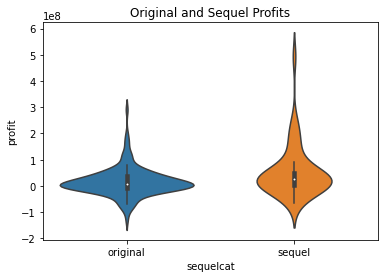

In [53]:
# For the simplicity (including coloring), I chose to use Seanborn:

sns.violinplot(data = df_movie
                ,x = 'sequelcat'
                ,y = 'profit'
                    ).set(
                        title = 'Original and Sequel Profits'
                );

### 2.2 Winsorisation
- Create a new column `likes_winsor` in `df_movie` with a 5% winsorised version of the column `likes`. To make sure the winsorising worked, compare the minimum and maximum values of the two columns.
- Create a new column `ratingscat` based on `ratings` in `df_movie`, which describes the ratings category of a movie. Distinguish between the following categories:
    - `negative`: $0 <= ratings < 6$
    - `neutral`: $6 <= ratings < 6.8$
    - `positive`: $6.8 <= ratings <= 10$

In [59]:
# Created a new winsorized column

df_movie['likes_winsor'] = winsorize(
                                    df_movie['likes']
                                    ,limits= [0.05, 0.05]
                                    )
df_movie.head(3)

,movie,year,ratings,genre,gross,budget,screens,sequel,sequelcat,sentiment,views,likes,dislikes,comments,aggregate_followers,profit,likes_winsor,ratingscat
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,original,0,3280543,4632,425,636,1120000.0,-3990870.0,4632,neutral
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,sequel,2,583289,3465,61,186,12350000.0,142000000.0,3465,positive
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,original,0,304861,328,34,47,483000.0,2700000.0,328,neutral


In [55]:
# Create a new categorised column using apply + lambda function

def categorise(row):  
    if row['ratings'] >= 0 and row['ratings'] <= 6:
        return 'negative'
    elif row['ratings'] >= 6 and row['ratings'] <= 6.8:
        return 'neutral'
    elif row['ratings'] >= 6.8 and row['ratings'] <= 10:
        return 'positive'
    return 'NA'

df_movie['ratingscat'] = df_movie.apply(lambda row: categorise(row), axis=1)
df_movie.head(3)

,movie,year,ratings,genre,gross,budget,screens,sequel,sequelcat,sentiment,views,likes,dislikes,comments,aggregate_followers,profit,likes_winsor,ratingscat
0,13 Sins,2014,6.3,8,9130,4000000.0,45.0,1,original,0,3280543,4632,425,636,1120000.0,-3990870.0,4632,neutral
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306.0,2,sequel,2,583289,3465,61,186,12350000.0,142000000.0,3465,positive
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872.0,1,original,0,304861,328,34,47,483000.0,2700000.0,328,neutral


### 2.3 Create a Scatter Plot
Create a scatter plot for `gross` over `likes_winsor` in `df_movie`. This means that `likes_winsor` should occupy the x-Axis, and `gross` the y-Axis. Indicate the
different `ratingscat` categories by colouring movies with `negative` ratings in *Red*, `neutral` ratings in *Blue*, and `positive` ratings in *Green*. Please use an appropriate title and axis labels, as well as a legend.

Hint: Look at [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

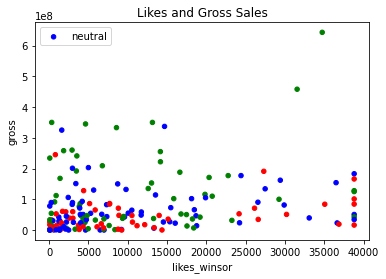

In [73]:
# Use plt to create a sacatter plot using series likes_winsor and gross

from calendar import c


colors = {'negative':'red', 'neutral':'blue', 'positive':'green'}
plt.scatter(df_movie['likes_winsor'], df_movie['gross'], c=df_movie['ratingscat'].map(colors), s = 20)

# Define the graph title, axis names and legend, add grid
plt.title('Likes and Gross Sales')
plt.xlabel('likes_winsor')
plt.ylabel('gross')
plt.legend(df_movie['ratingscat'])
plt.show()

## Exercise 3 (5 marks): Hypothesis testing

### Exercise 3.1 (1 mark)
- Create a new dataframe `df_movie_stats` which groups `df_movie` by `ratingscat` and `sequelcat` to describe each group by the number of observations and the means and standard deviations of `profit`, `gross`, and `budget`. `df_movie_stats` will hence contain six rows (3 possible values for `ratingscat` * 2 possible values for `sequelcat`) and have the columns `N`, `profit_mean`, `profit_std`, `gross_mean`, `gross_std`, `budget_mean`, and `budget_std`.
- `print` `df_movie_stats` to the console.

Hint: Look up [`pd.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [`pd.DataFrame.agg`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html).

In [76]:
# Create a new dataframe with required statics using groupby and agg functions

df_movie_stats = df_movie.groupby(['ratingscat', 'sequelcat']).agg(
    {'profit': ['count', 'mean', 'std'],
    'gross': ['count', 'mean', 'std'],
    'budget': ['count', 'mean', 'std']}
)
df_movie_stats

profit                             gross                \
                      count          mean           std count          mean   
ratingscat sequelcat                                                          
negative   original      43  2.574623e+06  4.774507e+07    43  4.217148e+07   
           sequel        10  2.200300e+07  1.946555e+07    10  6.025300e+07   
neutral    original      55  7.660745e+06  3.988544e+07    55  4.667043e+07   
           sequel        21  3.689048e+07  8.093483e+07    21  1.140714e+08   
positive   original      47  3.611279e+07  6.411764e+07    47  8.595109e+07   
           sequel        11  1.115455e+08  1.440440e+08    11  2.820000e+08   

                                   budget                              
                               std  count          mean           std  
ratingscat sequelcat                                                   
negative   original   4.368133e+07     43  3.959686e+07  4.181672e+07  
           sequel     7.107304e+07     10  3.825000e+07  6.236508e+07  
neutral    original   5.031014e+07     55  3.900969e+07  4.288043e+07  
           sequel     8.720937e+07     21  7.718095e+07  4.845624e+07  
positive   original   9.352380e+07     47  4.983830e+07  5.445318e+07  
           sequel     1.492830e+08     11  1.704545e+08  5.506608e+07

In [78]:
# Create a new dataframe with required statics using groupby and agg functions

df_movie_stats = df_movie.groupby(['ratingscat', 'sequelcat']).agg(
    profit_N = pd.NamedAgg(column='profit', aggfunc= 'count'),
    profit_mean = pd.NamedAgg(column='profit', aggfunc= 'mean'),
    profit_std = pd.NamedAgg(column='profit', aggfunc= 'std'),
    gross_N = pd.NamedAgg(column='gross', aggfunc= 'count'),
    gross_mean = pd.NamedAgg(column='gross', aggfunc= 'mean'),
    gross_std = pd.NamedAgg(column='gross', aggfunc= 'std'),
    budget_N = pd.NamedAgg(column='budget', aggfunc= 'count'),
    budget_mean = pd.NamedAgg(column='budget', aggfunc= 'mean'),
    budget_std = pd.NamedAgg(column='budget', aggfunc= 'std'),
)
df_movie_stats

profit_N   profit_mean    profit_std  gross_N  \
ratingscat sequelcat                                                  
negative   original         43  2.574623e+06  4.774507e+07       43   
           sequel           10  2.200300e+07  1.946555e+07       10   
neutral    original         55  7.660745e+06  3.988544e+07       55   
           sequel           21  3.689048e+07  8.093483e+07       21   
positive   original         47  3.611279e+07  6.411764e+07       47   
           sequel           11  1.115455e+08  1.440440e+08       11   

                        gross_mean     gross_std  budget_N   budget_mean  \
ratingscat sequelcat                                                       
negative   original   4.217148e+07  4.368133e+07        43  3.959686e+07   
           sequel     6.025300e+07  7.107304e+07        10  3.825000e+07   
neutral    original   4.667043e+07  5.031014e+07        55  3.900969e+07   
           sequel     1.140714e+08  8.720937e+07        21  7.718095e+07   
positive   original   8.595109e+07  9.352380e+07        47  4.983830e+07   
           sequel     2.820000e+08  1.492830e+08        11  1.704545e+08   

                        budget_std  
ratingscat sequelcat                
negative   original   4.181672e+07  
           sequel     6.236508e+07  
neutral    original   4.288043e+07  
           sequel     4.845624e+07  
positive   original   5.445318e+07  
           sequel     5.506608e+07

### Exercise 3.2 (1 mark)
- Based on `df_movie`, use a Bartlett’s test to test for variance homogeneity in the column `profit` across the three different ratings categories (column: `ratingscat`). `print` the resulting test statistic and p-value to the console.
- In your own words, explain what the null hypothesis is, and then interpret the results of the test.

Hint: Look at [`scipy.stats.bartlett`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html).

In [79]:
# Create a dataframe that contains profits from three rating categories
data1 = [df_movie[df_movie['ratingscat'] == 'negative']['profit'],
        df_movie[df_movie['ratingscat'] == 'neutral']['profit'],
        df_movie[df_movie['ratingscat'] == 'positive']['profit']]
  
# performing Bartlett's test using the created dataframe.
test_statistic, p_value = stats.bartlett(data1[0], data1[1], data1[2])
  
print(test_statistic, p_value)

28.825665604723685 5.502831888773135e-07


#### <span style="color:#E2C382;">*Answer:*</span>
The Null Hypo is that the three groups have homogeneous variance. If we consider the level of significance of alpha value to be 0.05, since the p-value is larger than 0.05, the Null Hypo is accepted. 

### Exercise 3.3 (1 mark)
- Again based on `df_movie`, use a one‐way Analysis of Variance (ANOVA) to test whether there is a difference in mean `profit` across the three different ratings categories (column: `ratingscat`). `print` the resulting test statistic and p-value to the console.
- In your own words, explain what the null hypothesis is, and then interpret the results of the test.

Hint: Look at [`scipy.stats.f_oneway`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html).

In [80]:
# Use the previously defined dataframe, perform an ANOVA test

F, p = f_oneway(data1[0], data1[1], data1[2])
print (F, p)

7.362966819545399 0.0008391149952215098


#### <span style="color:#E2C382;">*Answer:*</span>
Because the previous test shows that the variances across three groups are homogeneous, we can continue with one-way ANOVA with its precondition satisfied. 

The Null Hypo here is that the three groups have equal means. If we consider the level of significance of alpha value to be 0.05, since the p-value is smaller than 0.05, the Null Hypo is rejected, and we can conclude that the three groups do not have equal means. 

### Exercise 3.4 (1 mark)
Continue working on the differences in mean `profit` between the `ratingscat` categories in `df_movie`.
- Conduct a PostHoc analysis with Tukey HSD to determine which pairs of categories (if any) have significantly different means from each other. `print` the results to the console.
- In your own words, interpret the results of the test.

Hint: Look at [`statsmodels.stats.multicomp.MultiComparison`](https://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html). `MultiComparison` has been imported above.

In [81]:
# Use the tukeyhsd function to perform the test
tukey = pairwise_tukeyhsd(
                          df_movie['profit']
                          ,df_movie['ratingscat']
                        )
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
 group1   group2     meandiff   p-adj      lower          upper     reject
--------------------------------------------------------------------------
negative  neutral   9497026.771  0.694 -18023931.1813 37017984.7234  False
negative positive 44178628.6077 0.0013  14955750.9156 73401506.2998   True
 neutral positive 34681601.8366 0.0072   7868625.2568 61494578.4165   True
--------------------------------------------------------------------------


#### <span style="color:#E2C382;">*Answer:*</span>
Because the previous test shows that there are differences in means across the three groups, we can continue to find out which means are actually different from each other using HSD method. 

The tukey HSD output reveals that there are significant differences between negative and positive, as well as neutral and positive. The former has a greater difference in mean. The p-adjusted values also verify this as they are lower than 0.05.

### Exercise 3.5 (1 mark)
- Based on `df_movie`, compare the mean `profit`s for `original` and `sequel` movies (column: `sequelcat`).
- Choose an appropriate test to determine whether there is a significant difference. Conduct the test and `print` the results to the console.
- Explain your test choice and the results in your own words.

Hint: An additional test may be required to determine which test to use for comparing the means.

In [82]:
# Define the profits from each of the two categories, and then perform t test:

a = df_movie[df_movie['sequelcat'] == 'original']['profit']
b = df_movie[df_movie['sequelcat'] == 'sequel']['profit']
result = stats.ttest_ind(a, b)
print(result)

Ttest_indResult(statistic=-3.2646195173313126, pvalue=0.0013058671642412372)


#### <span style="color:#E2C382;">*Answer:*</span>
Because we are simply comparing the means between two groups, the T-test is a better option compared to ANOVA. 

The result shows a p-value lower than 0.05, which means we need to reject the Null hypothesis that the two means are equal. Therefore, we conclude that the there is a significant difference between the means of the two groups in sequel categories. 